In [120]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph.state import StateGraph, START, END
from pydantic import BaseModel, Field
from typing import TypedDict, Literal
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import Image, display,Markdown

load_dotenv()

True

In [121]:
gpt_llm= ChatOpenAI(model= "gpt-4o-mini")

In [122]:
class Classifier(BaseModel):
    workflow_type: Literal["GenAI","Machine Learning",None] = Field(description="This field is a classfier of a question based on Generative AI or machine learning")


In [123]:
structured_output = gpt_llm.with_structured_output(Classifier)

In [124]:
class State(TypedDict):
    topic: str
    workflow_type: str
    general_output: str
    sequential_output: str
    sequence_summary_output: str
    parallel_blog_output: str
    parallel_bullets_output: str
    combine_parallel_output: str
    

In [125]:
def classifier_agent(state:State) -> State:
    prompt_template = ChatPromptTemplate.from_messages(
        [
            ("system","You are a classifier assistant which classifies the user questions based on GenAI and machine learning."),
            ("human",f"please help in classifying the question from the user: {state['topic']}")
        ]
    )

    chain =  prompt_template | structured_output 

    response = chain.invoke({"topic":state['topic']})

    return {"workflow_type":response.workflow_type}
    

In [126]:
def classifier_condition(state:State) -> Literal["genai_agent","machine_learning_agent","general_responder"]:
    if state["workflow_type"]=="GenAI":
        return "genai_agent"
    elif state["workflow_type"]=="Machine Learning":
        return "machine_learning_agent"
    else:
        return "general_responder"

In [127]:
def genai_agent(state:State)-> State:
    prompt_template = ChatPromptTemplate.from_messages(
        [
            ("system","You are an LLM which generates 3 paragraph for the topic given by the user."),
            ("human",f"Please help in generating 3 paragraph for the topic: {state['topic']}")
        ]
    )

    chain =  prompt_template | gpt_llm | StrOutputParser() 

    response = chain.invoke({"topic":state['topic']})

    return {"sequential_output":response}

In [128]:
def genai_agent_summarizer(state:State)-> State:
    prompt_template = ChatPromptTemplate.from_messages(
        [
            ("system","You are an LLM generator which helps in summarizing the output."),
            ("human",f"Please help in generating summary for the output: {state['sequential_output']}")
        ]
    )

    chain =  prompt_template | gpt_llm | StrOutputParser() 

    response = chain.invoke({"sequential_output":state['sequential_output']})

    return {"sequence_summary_output":response}

In [129]:
def machine_learning_agent(state:State)-> State:

    return {"topic":state['topic']}

In [130]:
def machine_learning_agent_blog(state:State)-> State:
    prompt_template = ChatPromptTemplate.from_messages(
        [
            ("system","You are an LLM which generates 5 lines blogs for the topic given by the user."),
            ("human",f"Please help in generating 5 lines blogs for the topic: {state['topic']}")
        ]
    )

    chain =  prompt_template | gpt_llm | StrOutputParser() 

    response = chain.invoke({"topic":state['topic']})

    return {"parallel_blog_output":response}

In [131]:
def machine_learning_agent_bullets(state:State)-> State:
    prompt_template = ChatPromptTemplate.from_messages(
        [
            ("system","You are an agent that writes 5 bullet facts about the user topic"),
            ("human",f"Please help in generating 5 bullet facts about the topic: {state['topic']}")
        ]
    )

    chain =  prompt_template | gpt_llm | StrOutputParser() 

    response = chain.invoke({"topic":state['topic']})

    return {"parallel_bullets_output":response}

In [132]:
def machine_learning_agent_combinator(state:State)-> State:
    prompt_template = ChatPromptTemplate.from_messages(
        [
            ("system","You are an agent that helps combining both the blogs and bullet points."),
            ("human",f"Please help in combining blogs: \n \n {state["parallel_blog_output"]} and bullet facts: \n\n {state["parallel_bullets_output"]}")
        ]
    )

    chain =  prompt_template | gpt_llm | StrOutputParser()  

    response = chain.invoke({"parallel_blog_output":state["parallel_blog_output"], "parallel_bullets_output":state["parallel_bullets_output"]})

    return {"combine_parallel_output":response}

In [133]:
def general_responder(state:State)-> State:
    prompt_template = ChatPromptTemplate.from_messages(
        [
            ("system","You are an AI assistant who helps answering user questions."),
            ("human",f"Please help answering the user question: \n \n {state["topic"]}")
        ]
    )

    chain =  prompt_template | gpt_llm | StrOutputParser()  

    response = chain.invoke({"topic":state["topic"]})

    return {"general_output":response}

In [134]:
graph=StateGraph(State)

graph.add_node("classifier_agent",classifier_agent)
graph.add_node("genai_agent",genai_agent)
graph.add_node("genai_agent_summarizer",genai_agent_summarizer)
graph.add_node("machine_learning_agent",machine_learning_agent)
graph.add_node("machine_learning_agent_blog",machine_learning_agent_blog)
graph.add_node("machine_learning_agent_bullets",machine_learning_agent_bullets)
graph.add_node("machine_learning_agent_combinator",machine_learning_agent_combinator)
graph.add_node("general_responder",general_responder)


graph.add_edge(START, "classifier_agent")
graph.add_conditional_edges("classifier_agent",classifier_condition)
graph.add_edge("genai_agent", "genai_agent_summarizer")
graph.add_edge("genai_agent_summarizer", END)
graph.add_edge("machine_learning_agent", "machine_learning_agent_blog")
graph.add_edge("machine_learning_agent", "machine_learning_agent_bullets")
graph.add_edge("machine_learning_agent_bullets", "machine_learning_agent_combinator")
graph.add_edge("machine_learning_agent_blog", "machine_learning_agent_combinator")
graph.add_edge("machine_learning_agent_combinator", END)
graph.add_edge("general_responder", END)


workflow=graph.compile()

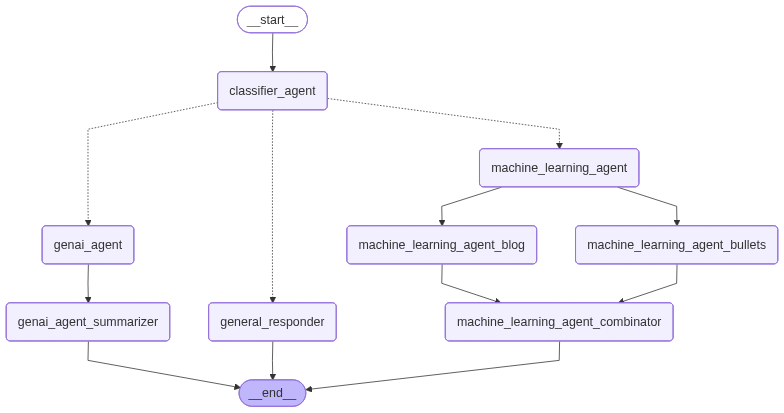

In [135]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [136]:
workflow.invoke({"topic":"what is parallel chain in langgraph?"})

{'topic': 'what is parallel chain in langgraph?',
 'workflow_type': 'GenAI',
 'sequential_output': "In the context of LangGraph, a parallel chain is a structured approach to manage and organize the flow of information and tasks that occur simultaneously within a language processing framework. LangGraph, being a graph-based representation of language structures, leverages the concept of parallel chains to enhance the efficiency of processing complex tasks that require multiple operations to be executed concurrently. This is particularly important in natural language processing (NLP) applications where different components, such as parsing, semantic analysis, and machine translation, can be executed in parallel to improve overall performance and reduce latency.\n\nParallel chains in LangGraph function by enabling multiple nodes within the graph to operate independently yet cohesively, allowing for various tasks to progress without waiting for one another to complete. This parallelization

In [140]:
workflow.invoke({"topic":"what is sequencing in database?"})

{'topic': 'what is sequencing in database?',
 'workflow_type': None,
 'general_output': 'Sequencing in database contexts typically refers to the process of generating a sequence of unique numbers or values, often used for primary keys in a database table. A sequence can be defined to automatically generate numerical values in a specific order. This is particularly useful for ensuring that each record in a table has a unique identifier.\n\nHere are some key points about sequencing in databases:\n\n1. **Unique Identifier**: Sequences ensure that each entry in a table can be uniquely identified, which is crucial for maintaining data integrity.\n\n2. **Automatic Generation**: Sequences can be automatically incremented, meaning that each time a new record is added, a new unique value is generated without the need for manual input.\n\n3. **Customization**: Many database management systems (DBMS) allow customization of sequences, such as setting the starting value, increment size, and whether

In [138]:
result=workflow.invoke({"topic":"what is overfitting?"})

In [139]:
Markdown(result["combine_parallel_output"])

**Understanding Overfitting in Machine Learning**

Overfitting is a prevalent challenge in the realm of machine learning, where a model learns not only the essential underlying patterns in the training data but also the noise within it. This leads to excessive complexity, resulting in a model that performs exceptionally well on the training set but poorly on unseen data. Consequently, the model struggles to generalize effectively, which can severely hinder its predictive capability.

**Key Characteristics of Overfitting**:

- **Definition**: Overfitting occurs when a model captures noise in the training data, leading to its failure when exposed to new data points.
  
- **Symptoms**: A significant symptom of overfitting is a pronounced disparity between training and validation performance. For instance, a model might demonstrate a very low error rate on the training data while exhibiting a considerably higher error rate on the test data.

- **Complex Models**: The likelihood of overfitting increases with more complex models, particularly those having a large number of parameters compared to the number of observations. Such models can inadvertently craft highly specific rules that cater directly to the training data.

**Strategies to Mitigate Overfitting**:

To combat overfitting, several strategies can be employed:

- **Prevention Techniques**: Techniques such as cross-validation, regularization (including L1 and L2), pruning, and incorporating dropout layers in neural networks are effective methods for reducing the risk of overfitting. Additionally, simplifying the model can enhance its ability to generalize.

- **Evaluation Metrics**: Monitoring specific evaluation metrics, including validation loss, confusion matrix, and F1 score, can provide valuable insights into model performance. This vigilance helps identify when overfitting is occurring, allowing for timely interventions.

In conclusion, striking a balance between model complexity and generalization is vital for developing robust predictive models. By understanding the signs of overfitting and implementing appropriate strategies, data scientists can create models that perform well on both seen and unseen data.